#  Modules

In [36]:
import pandas as pd
import urllib.request
import json
import pycountry 
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests

# 1.Function to fetch data from URL

In [57]:
def html_to_df(url, clean_empty = False , attrs = {}, helper = None):
    html_content = requests.get(url).text
    soup = bs(html_content, "lxml")
    table = str(soup.find("table", attrs=attrs))
    df = pd.read_html(str(table))[0]
    
    if clean_empty :
        df = df.loc[:, ~df.isnull().all(axis = 0)]
        
    if helper:
        df = helper(df)   
    return df

In [58]:
url = "https://github.com/robert456456456456/Web_server_log_parser/blob/master/devops.log"

# 2.Function to fetch data from URL

In [60]:
def helper(df):
    df = pd.DataFrame(list(df[1].apply(lambda x: x.split())))
    df[3] = df[3].apply(lambda x: x.replace('[','') )
    df[4] = df[4].apply(lambda x: x.replace(']','') )
    df[5] = df.apply(lambda x : ' '.join([x[5],x[6]]).replace('"',''), axis = 1)
    df.drop([1,2,7,6],inplace=True,axis = 1)
    
    return df

# 3.Cleaning Data

In [ ]:
df = html_to_df(url,clean_empty=True, helper=helper)

In [62]:
df.head()

,0,3,4,5,8,9
0,64.242.88.10,07/Mar/2004:16:05:49,-0800,GET /twiki/bin/edit/Main/Double_bounce_sender?...,401,12846
1,64.242.88.10,07/Mar/2004:16:06:51,-0800,GET /twiki/bin/rdiff/TWiki/NewUserTemplate?rev...,200,4523
2,64.242.88.10,07/Mar/2004:16:10:02,-0800,GET /mailman/listinfo/hsdivision,200,6291
3,64.242.88.10,07/Mar/2004:16:11:58,-0800,GET /twiki/bin/view/TWiki/WikiSyntax,200,7352
4,64.242.88.10,07/Mar/2004:16:20:55,-0800,GET /twiki/bin/view/Main/DCCAndPostFix,200,5253


In [63]:
columns = ['User Address','Date/Time','GMT Offset', 'Action_Taken','Return ','Size']
df.columns  = columns
df.head()

,User Address,Date/Time,GMT Offset,Action_Taken,Return,Size
0,64.242.88.10,07/Mar/2004:16:05:49,-0800,GET /twiki/bin/edit/Main/Double_bounce_sender?...,401,12846
1,64.242.88.10,07/Mar/2004:16:06:51,-0800,GET /twiki/bin/rdiff/TWiki/NewUserTemplate?rev...,200,4523
2,64.242.88.10,07/Mar/2004:16:10:02,-0800,GET /mailman/listinfo/hsdivision,200,6291
3,64.242.88.10,07/Mar/2004:16:11:58,-0800,GET /twiki/bin/view/TWiki/WikiSyntax,200,7352
4,64.242.88.10,07/Mar/2004:16:20:55,-0800,GET /twiki/bin/view/Main/DCCAndPostFix,200,5253


# 4.Top visiter IP/User address:

In [64]:
df['User Address'].value_counts().head(5)

64.242.88.10                       452
10.0.0.153                         270
h24-71-236-129.ca.shawcable.net     51
cr020r01-3.sac.overture.com         44
h24-70-69-74.ca.shawcable.net       32
Name: User Address, dtype: int64

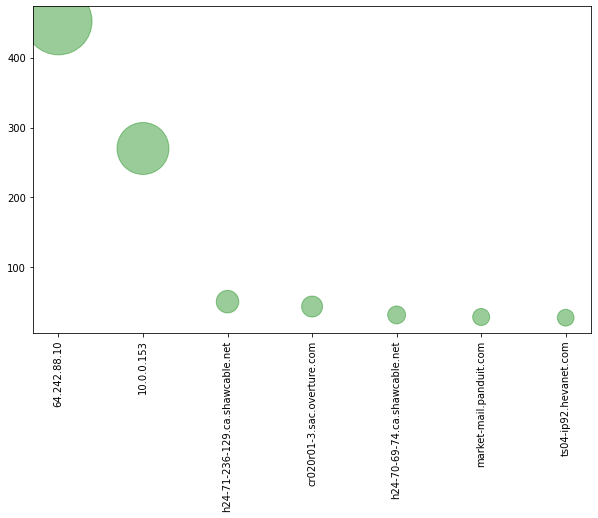

In [65]:
plt.figure(figsize = (10,6))

plt.scatter(df['User Address'].value_counts().index[0:7],
            df['User Address'].value_counts().values[0:7],
            s =  df['User Address'].value_counts().values[0:7]*10,
                  color='green', 
                 alpha=0.4)

plt.xticks( df['User Address'].value_counts().index[0:7],rotation='vertical');

# 5.Frequently visited pages

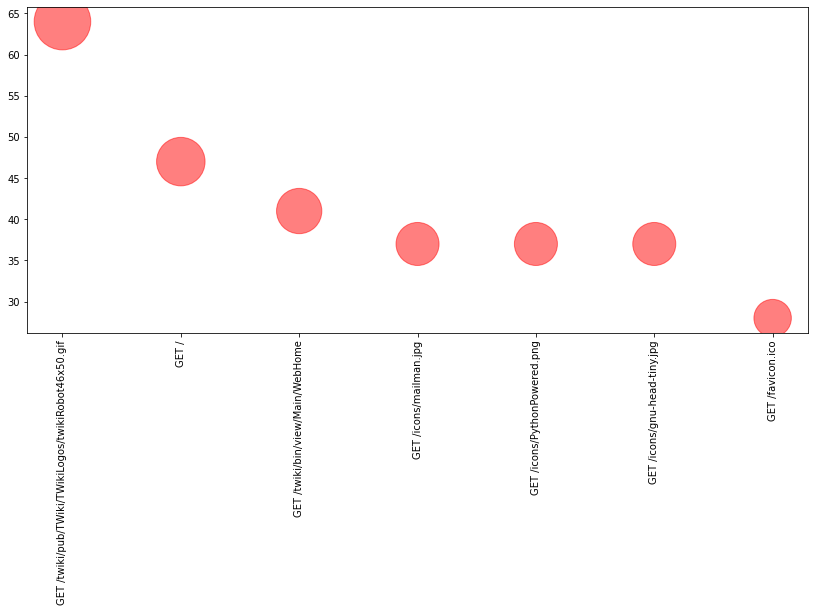

In [66]:
plt.figure(figsize = (14,6))

plt.scatter(df['Action_Taken'].value_counts().index[0:7],
            df['Action_Taken'].value_counts().values[0:7],
            s =  df['Action_Taken'].value_counts().values[0:7]*50,
                  color='red', 
                 alpha=0.5)

plt.xticks( df['Action_Taken'].value_counts().index[0:7],rotation='vertical');

# 6.Geolocation from Address

In [68]:
def ip_loc(x):
    url = "https://geolocation-db.com/jsonp/"+x
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode().split("(")[1].strip(")"))
    return {"country_code":data["country_code"], 'latitude':data['latitude'],'longitude':data['longitude']}

In [69]:
from tqdm.notebook import tqdm
ip_info = {}
for i in tqdm(df['User Address'].unique()):
    ip_info[i] = ip_loc(i)


  0%|          | 0/172 [00:00<?, ?it/s]

In [71]:
df["Country"] = df["User Address"].apply(lambda x: ip_info[x]["country_code"])
df['latitude'] = df["User Address"].apply(lambda x: ip_info[x]['latitude'])
df['longitude'] = df["User Address"].apply(lambda x: ip_info[x]['longitude'])

In [72]:
def code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(alpha_2=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

In [73]:
df['country_code'] = code(df['Country'])

# 7.Plotting of no of users

In [74]:
df.head()

,User Address,Date/Time,GMT Offset,Action_Taken,Return,Size,Country,latitude,longitude,country_code
0,64.242.88.10,07/Mar/2004:16:05:49,-0800,GET /twiki/bin/edit/Main/Double_bounce_sender?...,401,12846,US,37.751,-97.822,USA
1,64.242.88.10,07/Mar/2004:16:06:51,-0800,GET /twiki/bin/rdiff/TWiki/NewUserTemplate?rev...,200,4523,US,37.751,-97.822,USA
2,64.242.88.10,07/Mar/2004:16:10:02,-0800,GET /mailman/listinfo/hsdivision,200,6291,US,37.751,-97.822,USA
3,64.242.88.10,07/Mar/2004:16:11:58,-0800,GET /twiki/bin/view/TWiki/WikiSyntax,200,7352,US,37.751,-97.822,USA
4,64.242.88.10,07/Mar/2004:16:20:55,-0800,GET /twiki/bin/view/Main/DCCAndPostFix,200,5253,US,37.751,-97.822,USA


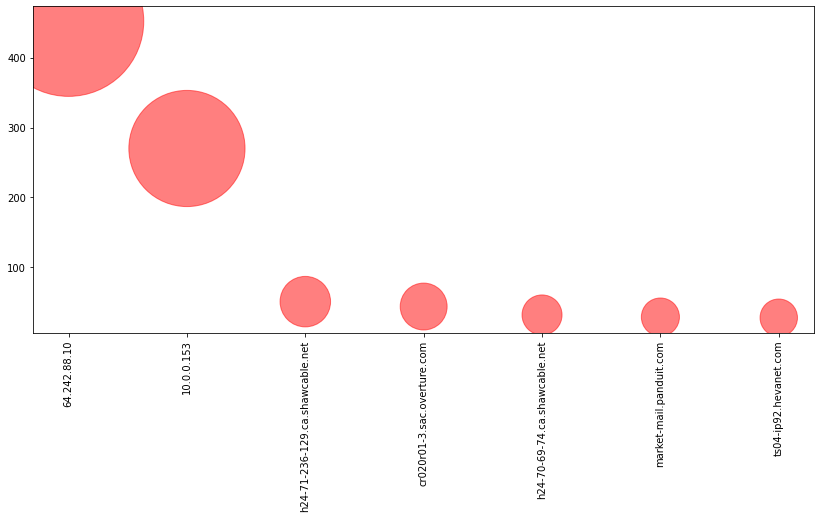

In [75]:
plt.figure(figsize = (14,6))

plt.scatter(df['User Address'].value_counts().index[0:7],
            df['User Address'].value_counts().values[0:7],
            s =  df['User Address'].value_counts().values[0:7]*50,
                  color='red', 
                 alpha=0.5)

plt.xticks( df['User Address'].value_counts().index[0:7],rotation='vertical');